# Comparación entre CNNs y MLPs para la clasificación de imágenes

In [11]:
# Divide arrays o matrices en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Lee los archivos binarios del CIFAR-10.
import pickle
import numpy as np
import os
import torch
import random
# DataLoader (itera batches) y TensorDataset (dataset sencillo que empareja tensores de inputs y labels) desde PyTorch.
from torch.utils.data import DataLoader, TensorDataset
# Módulo de transformaciones de torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
import time
import matplotlib.pyplot as plt


## Cargar los batches 

In [12]:
ruta = "C:\\Users\\brend\\OneDrive\\Escritorio\\Documentos\\Doctorado\\Proyecto\\Datos\\cifar-10-batches-py"

# Función para cargar un batch
def cargar_batch(path):
    # Abre el archivo en modo binario lectura
    with open(path, 'rb') as f:
        # CIFAR viene serializado con pickle y las keys suelen ser bytes
        batch = pickle.load(f, encoding='bytes')
    # Convierte las claves del diccionario de bytes a str    
    batch = {k.decode('utf8'): v for k, v in batch.items()}
    return batch['data'], batch['labels']

# Cargar todos los batches de entrenamiento
data_list, labels_list = [], []
for i in range(1, 6):
    data_batch, labels_batch = cargar_batch(os.path.join(ruta, f"data_batch_{i}"))
    # Añade la matriz de ese batch a data_list
    data_list.append(data_batch)
    # Extiende la lista de etiquetas con las etiquetas del batch
    labels_list += labels_batch

# Concatenar los batches de entrenamiento
# Concatena las 5 matrices en una sola
X_train = np.concatenate(data_list)
# Convierte la lista de etiquetas acumulada en un array NumPy
y_train = np.array(labels_list)

# Cargar batch de test
X_test, y_test = cargar_batch(os.path.join(ruta, "test_batch"))
y_test = np.array(y_test)

# Concatenar entrenamiento + test (Concatena los 50k de entrenamiento con los 10k de test)
X_all = np.concatenate([X_train, X_test])
y_all = np.concatenate([y_train, y_test])

print(f"Datos combinados: {X_all.shape}, Etiquetas combinadas: {y_all.shape}")

Datos combinados: (60000, 3072), Etiquetas combinadas: (60000,)


## Fijar semilla para reproducibilidad


In [13]:
SEED = 50
# Fija la semilla del generador aleatorio de Python
random.seed(SEED)
# Fija la semilla de NumPy
np.random.seed(SEED)
# Fija la semilla para operaciones en CPU de PyTorch
torch.manual_seed(SEED)
# Fija la semilla para todas las GPUs disponibles
torch.cuda.manual_seed_all(SEED)
# Forzar resultados idénticos cada vez que se corra el código
torch.backends.cudnn.deterministic = True
# Evita variabilidad por elegir algoritmos diferentes
torch.backends.cudnn.benchmark = False

## Dividir en train / validation / test (80/10/10)

-Sacar el 10% (0.1) del total para X_test/y_test (6000 imagenes para test)

-X_temp contiene el resto (54000 imagenes restantes)

-De las 54000 imágenes en X_temp, toma exactamente 6,000 imágenes para validación

-El resto (48,000 imagenes) queda para entrenamiento

In [14]:
# Separar 10% para test (6000 imágenes)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_all, y_all, test_size=0.1, random_state=SEED, stratify=y_all
)

# Separar 1/8 del resto para validación → 10% del total (6,000 imágenes)
X_train, X_val, y_train, y_val = train_test_split(
    # X_temp separa 6000 elementos para validación, dejando 48000 en X_train
    X_temp, y_temp, test_size=6000, random_state=SEED, stratify=y_temp
)

## Normalización y reshape para imágenes 32x32x3

-CIFAR-10 original almacena cada imagen como un vector de 3072 valores = 3 canales * 32 * 32 pixeles

-reshape(-1, 3, 32, 32) = convierte el vector plano a imagen con canales separados

-.transpose(0, 2, 3, 1) = cambia el orden de ejes:

    De (N, 3, 32, 32)  CHW → Channels, Height, Width a (N, 32, 32, 3)  HWC → Height, Width, Channels

-Se divide entre 255 para normalizar pixeles de 0–255 a 0–1:

    Negro: 0 / 255 = 0

    Blanco: 255 / 255 = 1

In [15]:
# -1 deja que Python calcule cuántas imágenes hay
X_train = X_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.0
X_val   = X_val.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.0
X_test  = X_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.0

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Etiquetas: {y_train.shape}, {y_val.shape}, {y_test.shape}")

Train: (48000, 32, 32, 3), Val: (6000, 32, 32, 3), Test: (6000, 32, 32, 3)
Etiquetas: (48000,), (6000,), (6000,)


## Transformaciones (data augmentation)

-X_train.transpose(0,3,1,2) cambia de HWC a CHW: (N,32,32,3) → (N,3,32,32), que es el formato que espera PyTorch.

-DataLoader en PyTorch toma un dataset y lo convierte en un iterador de mini-batches

In [16]:

# RandomHorizontalFlip() voltea aleatoriamente horizontales (augmentación)
# RandomCrop(32, padding=4) recorta aleatoriamente 32×32 con padding de 4 píxeles (augmentación)
# ToTensor() convierte imágenes PIL o numpy HWC uint8 a tensores CHW con escala a [0,1]
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

# Convertir arrays numpy a tensores

# torch.tensor(...-, dtype=torch.float32) crea tensores float32 con copia desde NumPy
# Las etiquetas se convierten a torch.long (int64), formato requerido por la mayoría de las pérdidas de clasificación
train_data = torch.tensor(X_train.transpose(0,3,1,2), dtype=torch.float32)
val_data = torch.tensor(X_val.transpose(0,3,1,2), dtype=torch.float32)
test_data = torch.tensor(X_test.transpose(0,3,1,2), dtype=torch.float32)
# torch.tensor() copia datos
train_labels = torch.tensor(y_train, dtype=torch.long)
val_labels = torch.tensor(y_val, dtype=torch.long)
test_labels = torch.tensor(y_test, dtype=torch.long)

# Datasets y DataLoaders
train_dataset = TensorDataset(train_data, train_labels)
val_dataset = TensorDataset(val_data, val_labels)
test_dataset = TensorDataset(test_data, test_labels)

# Se envían 128 imágenes por vez y shuffle=True mezcla los datos en cada epoch
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

## Arquitectura MLP

-input_size=3072: número de entradas que tendrá la red (por ejemplo, imágenes de 32x32x3 → 32323 = 3072)

-num_classes=10: número de salidas de la red 

-dropout_rate=0.3: porcentaje de neuronas que se apagan aleatoriamente para evitar overfitting

-ReLU → activa las neuronas y permite aprender relaciones complejas:

    Si la neurona recibe un valor positivo → lo deja pasar

    Si recibe un valor negativo → lo convierte en 0

-Dropout → apaga aleatoriamente neuronas para evitar memorizar datos (overfitting)

In [17]:
class MLP(nn.Module):
    def __init__(self, input_size=3072, num_classes=10, dropout_rate=0.3):
        # Llama al constructor de la clase padre (nn.Module) para inicializar correctamente la red
        super(MLP, self).__init__()
        # Capas totalmente conectadas
        self.fc1 = nn.Linear(input_size, 512) #input_size (3072) a 512 neuronas
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        # Capa de salida
        self.out = nn.Linear(128, num_classes) # de 128 neuronas a num_classes (10)
        # Define la capa de dropout, que desactiva aleatoriamente un porcentaje de neuronas durante el entrenamiento
        self.dropout = nn.Dropout(dropout_rate)
    
   #Define el forward pass (cómo fluye la información a través de la red)
    def forward(self, x): # x es la entrada
        # Aplanar imágenes 32x32x3 → 3072
        # Convierte cada imagen de 3D a un vector 1D
        x = x.view(x.size(0), -1)
        # Aplica las capas: ReLU + dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        # Capa final de salida
        x = self.out(x)
        return x


## Arquitectura CNN

-self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1): entrada 3 canales (RGB), salida 32 mapas de características, kernel 3×3. padding=1 mantiene las dimensiones espaciales (por ejemplo, 32×32 → 32×32). Stride por defecto = 1

-self.conv1(x) → aplica un filtro convolucional a la entrada:

    Toma imágenes con 3 canales (RGB)
    Crea 32 mapas de características

-BatchNorm2d → normaliza cada canal para estabilizar el entrenamiento:

    Centra los valores alrededor de 0
    Escala a desviación estándar 1
    Ayuda a entrenar más rápido y evitar que el gradiente explote

-F.relu(...) → Aplica la activación ReLU:

    Valores negativos → se vuelven 0
    Valores positivos → se mantienen

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.3):
        super(SimpleCNN, self).__init__()
        
        # Bloques convolucionales
        # Capa convolucional
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # Normaliza las activaciones por batch, estabiliza y acelera el entrenamiento
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        # Max pooling 2×2 con stride 2. Reduce la resolución espacial a la mitad cada vez que se aplica (ej. 32→16)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128*4*4, 128)  # después de 3 MaxPool de tamaño 2 → 32→16→8→4
        # Capa final totalmente conectada que reduce de 128 a num_classes logits
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        # Aplica conv1 → bn1 → ReLU
        x = F.relu(self.bn1(self.conv1(x)))
        # Aplica max pooling a x
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        # Aplana el tensor para pasar a las capas fully connected. x.size(0) = batch size
        x = x.view(x.size(0), -1)
        # Aplica FC y la activación ReLU
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        # Capa final que produce los logits
        x = self.fc2(x)
        return x

## Inicialización de modelos y verificación de dimensiones

-Detecta si hay GPU disponible y elige usarla; si no, usa CPU

-Crea las dos redes neuronales (MLP y CNN)

-Mueve ambos modelos al dispositivo elegido (GPU o CPU).

-Genera un batch de imágenes falsas (8 imágenes RGB de 32×32, como CIFAR-10)

-Pasa ese batch por cada modelo para asegurarse de que:

    El modelo acepta el tamaño de entrada correctamente
    La salida tiene la forma correcta (batch_size, num_classes) = (8, 10)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mlp_model = MLP().to(device)
cnn_model = SimpleCNN().to(device)

# Probar shapes
sample_input = torch.randn(8, 3, 32, 32).to(device)
print("MLP output:", mlp_model(sample_input).shape)  
print("CNN output:", cnn_model(sample_input).shape)   

MLP output: torch.Size([8, 10])
CNN output: torch.Size([8, 10])


## Entrenamiento y evaluación comparativa de modelos (MLP vs CNN)

-Un optimizador es el componente que actualiza los pesos de la red neuronal para que vaya aprendiendo y en nuestro caso es el Adam:

    Ajusta los parámetros del modelo en cada iteración para intentar reducir el error
    Usa learning_rate para controlar qué tan grandes son los pasos al aprender

-El criterion es la función de pérdida y mide qué tan mal está prediciendo el modelo comparando la predicción con la etiqueta real:

    Recibe las probabilidades que predice la red y la clase correcta
    Calcula cuánto se equivocó
    Esa pérdida es lo que el optimizador trata de minimizar


===== Entrenando modelo: MLP =====
Epoch [1/50] Train Loss: 1.9994, Train Acc: 0.2551 Val Loss: 1.8348, Val Acc: 0.3377 (11.41s)
Epoch [2/50] Train Loss: 1.8442, Train Acc: 0.3347 Val Loss: 1.7498, Val Acc: 0.3637 (13.14s)
Epoch [3/50] Train Loss: 1.8010, Train Acc: 0.3524 Val Loss: 1.7370, Val Acc: 0.3687 (11.77s)
Epoch [4/50] Train Loss: 1.7695, Train Acc: 0.3605 Val Loss: 1.6794, Val Acc: 0.3950 (11.23s)
Epoch [5/50] Train Loss: 1.7305, Train Acc: 0.3788 Val Loss: 1.6483, Val Acc: 0.4100 (10.72s)
Epoch [6/50] Train Loss: 1.7168, Train Acc: 0.3827 Val Loss: 1.6713, Val Acc: 0.3967 (11.76s)
Epoch [7/50] Train Loss: 1.6973, Train Acc: 0.3895 Val Loss: 1.6297, Val Acc: 0.4208 (10.32s)
Epoch [8/50] Train Loss: 1.6768, Train Acc: 0.3971 Val Loss: 1.6251, Val Acc: 0.4230 (10.09s)
Epoch [9/50] Train Loss: 1.6662, Train Acc: 0.4001 Val Loss: 1.6064, Val Acc: 0.4278 (10.01s)
Epoch [10/50] Train Loss: 1.6581, Train Acc: 0.4036 Val Loss: 1.5838, Val Acc: 0.4385 (10.60s)
Epoch [11/50] Train Los

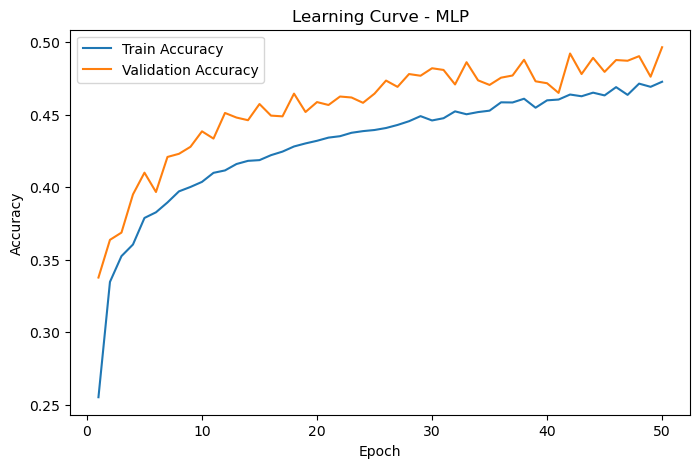


===== Entrenando modelo: CNN =====
Epoch [1/50] Train Loss: 1.3713, Train Acc: 0.5018 Val Loss: 1.2109, Val Acc: 0.5763 (54.91s)
Epoch [2/50] Train Loss: 1.0176, Train Acc: 0.6371 Val Loss: 0.9184, Val Acc: 0.6830 (56.90s)
Epoch [3/50] Train Loss: 0.8928, Train Acc: 0.6855 Val Loss: 0.8357, Val Acc: 0.7057 (55.67s)
Epoch [4/50] Train Loss: 0.8126, Train Acc: 0.7174 Val Loss: 0.7996, Val Acc: 0.7193 (56.68s)
Epoch [5/50] Train Loss: 0.7436, Train Acc: 0.7398 Val Loss: 0.7795, Val Acc: 0.7323 (54.75s)
Epoch [6/50] Train Loss: 0.6839, Train Acc: 0.7606 Val Loss: 0.7774, Val Acc: 0.7287 (55.86s)
Epoch [7/50] Train Loss: 0.6354, Train Acc: 0.7766 Val Loss: 0.7392, Val Acc: 0.7415 (57.74s)
Epoch [8/50] Train Loss: 0.5918, Train Acc: 0.7924 Val Loss: 0.8129, Val Acc: 0.7335 (58.33s)
Epoch [9/50] Train Loss: 0.5522, Train Acc: 0.8032 Val Loss: 0.8091, Val Acc: 0.7303 (59.60s)
Epoch [10/50] Train Loss: 0.5051, Train Acc: 0.8211 Val Loss: 0.7419, Val Acc: 0.7560 (59.79s)
Epoch [11/50] Train Los

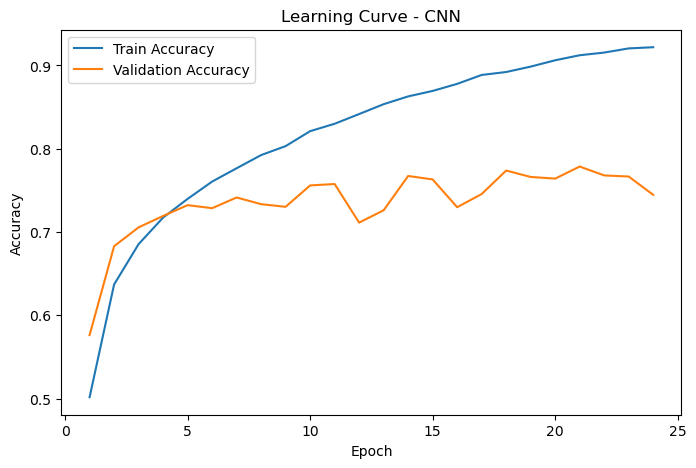


======== COMPARACIÓN FINAL =========

Modelo: CNN
  Train Acc Final: 0.9219
  Val   Acc Final: 0.7447
------------------------------------
Modelo: MLP
  Train Acc Final: 0.4727
  Val   Acc Final: 0.4965
------------------------------------


In [ ]:
learning_rate = 0.001
num_epochs = 50
# Número de épocas sin mejora en validación
patience = 10  
# Archivo donde se guarda el historial/resultados
results_file = "resultados_modelos.pkl"

# Detecta si hay GPU disponible; si sí usa "cuda", en otro caso "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Modelos a entrenar
model_dict = {
    "MLP": mlp_model,
    "CNN": cnn_model
}

# Función para contar parámetros
def count_parameters(model):
    # Devuelve la cantidad total de parámetros entrenables
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Cargar resultados previos si existen
try:
    with open(results_file, "rb") as f:
        results = pickle.load(f)
except:
    results = {}

# Loop principal de entrenamiento
for model_name, model in model_dict.items():
    print(f"\n===== Entrenando modelo: {model_name} =====")
    # Mueve el modelo a GPU/CPU según corresponda
    model = model.to(device)
    # Crea el optimizador Adam con la learning_rate
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # Función de pérdida para clasificación multi-clase
    criterion = nn.CrossEntropyLoss()
    
    # Guarda métricas por época
    history = {
        "train_loss": [], "train_acc": [],
        "val_loss": [], "val_acc": []
    }
    
    # Guardas los pesos del mejor modelo visto
    best_model_wts = copy.deepcopy(model.state_dict())
    # Inicializa infinito para poder comparar
    best_val_loss = float('inf')
    # Cuenta cuántas épocas consecutivas sin mejora en validación
    epochs_no_improve = 0
    
    # Marca tiempo de inicio para medir tiempo total de entrenamiento por modelo
    total_start = time.time()
    
    # Bucle principal de entrenamiento para medir duración por época
    for epoch in range(num_epochs):
        epoch_start = time.time()
        
        # Entrenamiento

        # Activa el comportamiento de entrenamiento
        model.train()
        # Inicializa acumuladores (running_loss, correct, total)
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            # Se mueven tensores a device, se calculan outputs, pérdida, loss.backward() y optimizer.step() para actualizar pesos
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Acumular pérdida ponderada por tamaño del batch (loss.item() * inputs.size(0)) y cuenta predicciones correctas
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        # Se alcula train_loss (promedio) y train_acc (fracción correcta)
        train_loss = running_loss / total
        train_acc = correct / total
        
        # Validación

        # Pone el modelo en modo evaluación
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        # Desactiva cálculo de gradientes
        with torch.no_grad():
            # Se calcula val_loss y val_acc de forma análoga al entrenamiento, pero sin pasos de backprop
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        val_loss /= val_total
        val_acc = val_correct / val_total
        
        # Guarda las métricas en history e imprime un resumen de la época con su duración
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        
        epoch_end = time.time()
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} "
              f"({epoch_end - epoch_start:.2f}s)")
        
        # Early stopping

        # Si la pérdida de validación mejora, actualiza best_val_loss y guardas pesos
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        # Si no mejora, incrementa epochs_no_improve. Si alcanza patience, para el loop (break) para evitar sobreajuste y ahorrar tiempo
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping en epoch {epoch+1}")
                break
    
    # Imprime tiempo total empleado en entrenar ese modelo
    total_end = time.time()
    print(f"Tiempo total de entrenamiento {model_name}: {total_end - total_start:.2f} s")
    
    # Guardar modelo y resultados

    # Carga los pesos del mejor modelo guardado en best_model_wts
    model.load_state_dict(best_model_wts)
    # Guarda los pesos en disco con torch.save
    torch.save(model.state_dict(), f"mejor_modelo_{model_name}.pth")
    # Almacena el history en el diccionario results y lo serializa con pickle (sobrescribe resultados_modelos.pkl)
    results[model_name] = history
    with open(results_file, "wb") as f:
        pickle.dump(results, f)
    
    # Imprime confirmación y cuenta parámetros entrenables
    print(f"✅ Entrenamiento de {model_name} terminado y guardado.")
    print(f"Parámetros entrenables: {count_parameters(model)}")
    
    # Evaluación en test
    model.eval()
    y_true, y_pred = [], []
    start_inference = time.time()
    with torch.no_grad():
        # Recorre test_loader sin gradientes, colecciona etiquetas verdaderas y predichas (en CPU, para métricas)
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    # Mide tiempo de inferencia total        
    end_inference = time.time()
    
    # Calcula métricas
    test_acc = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy {model_name}: {test_acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    
    # Calcula tiempo promedio de inferencia por imagen (en milisegundos)
    num_images = len(y_true)
    print(f"Inference time por imagen: {(end_inference - start_inference)/num_images*1000:.2f} ms")
    
    # Curva de aprendizaje
    epochs_range = range(1, len(history["train_acc"])+1)
    plt.figure(figsize=(8,5))
    plt.plot(epochs_range, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs_range, history["val_acc"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Learning Curve - {model_name}")
    plt.legend()
    plt.show()

# Comparación final si existen ambos
# Si ambos resultados existen, imprime un resumen final comparando train_acc y val_acc finales de cada modelo
if "MLP" in results and "CNN" in results:
    print("\n======== COMPARACIÓN FINAL =========\n")
    for m in results:
        print(f"Modelo: {m}")
        print(f"  Train Acc Final: {results[m]['train_acc'][-1]:.4f}")
        print(f"  Val   Acc Final: {results[m]['val_acc'][-1]:.4f}")
        print("------------------------------------")
